# Classifying STL10 images of everyday objects  using neural network, CNN, ResNets, Regularization and Data Augmentation in PyTorch

_A.K.A. Training an image classifier from scratch to over 90% accuracy in less than 5 minutes on a single GPU_

### Part of Course project of "Deep Learning with Pytorch: Zero to GANs"

The ability to try many different neural network architectures to address a problem is what makes deep learning really powerful, especially compared to shallow learning techniques like linear regression, logistic regression etc. 

In this notebook we  will:

1. Explore the STL10 dataset: https://cs.stanford.edu/~acoates/stl10/
2. Set up a training pipeline to train a neural network on a GPU
2. Experiment with different network architectures & hyperparameters


In [2]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet

Installing and Importing the required modules and classes from torch, torchvision, numpy, and matplotlib.

In [3]:
import os
import torch
import  torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import STL10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [4]:
# Project name used for jovian.commit
project_name = '06-stl10-project'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Exploring the STL10 dataset

We  download the data and create a PyTorch dataset using the STL10 class from torchvision.datasets.

In [6]:
# path to store/load data
dataset = STL10(root='/content/drive/MyDrive/data', download=True, transform=ToTensor())
test_dataset = STL10(root='/content/drive/MyDrive/data', split ='test', transform=ToTensor())
#dataset = STL10(root='data/', download=True, transform=ToTensor())
#test_dataset = STL10(root='data/', split ='test', transform=ToTensor())

Files already downloaded and verified


**The No of images in the training and testing dataset** 
**List the no of  output classes in the dataset**


In [7]:
dataset_size = len(dataset)
train_ds = dataset
test_dataset_size = len(test_dataset)
classes = dataset.classes
dataset_size,train_ds.data.shape,test_dataset_size,dataset.classes,len(dataset.classes)

(5000,
 (5000, 3, 96, 96),
 8000,
 ['airplane',
  'bird',
  'car',
  'cat',
  'deer',
  'dog',
  'horse',
  'monkey',
  'ship',
  'truck'],
 10)

**The shape of an image tensor from the dataset**

In [8]:
img, label = train_ds[0]
img_shape = img.shape
img_shape

torch.Size([3, 96, 96])

Note that this dataset consists of 3-channel color images (RGB). Let us look at a sample image from the dataset. `matplotlib` expects channels to be the last dimension of the image tensors (whereas in PyTorch they are the first dimension), so we'll the `.permute` tensor method to shift channels to the last dimension. Let's also print the label for the image.

Label (numeric): 1
Label (textual): bird


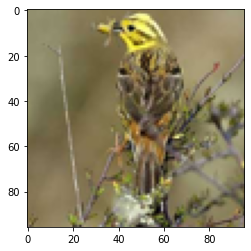

In [9]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

**The number of images belonging to each class**

In [10]:
count_class = {}
for _,outs in dataset: 
    labels = classes[outs]
    if labels not in count_class:
        count_class[labels] = 0
    count_class[labels] += 1 
count_class 

{'airplane': 500,
 'bird': 500,
 'car': 500,
 'cat': 500,
 'deer': 500,
 'dog': 500,
 'horse': 500,
 'monkey': 500,
 'ship': 500,
 'truck': 500}

Let's save our work to Jovian, before continuing.

In [11]:
!pip install jovian --upgrade --quiet

In [12]:
import jovian

In [13]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/venkatesh-vran/06-stl10-project


'https://jovian.ai/venkatesh-vran/06-stl10-project'

##### Preparing the data for training

We'll use a validation set with 1500 images . To ensure we get the same validation set each time, we'll set PyTorch's random number generator to a seed value of 43.

In [14]:
torch.manual_seed(43)
val_size = 1500
test_size = len(test_dataset) - val_size

Let's use the `random_split` method to create the training & validation sets

In [15]:
test_ds, val_ds = random_split(test_dataset, [test_size, val_size])
len(test_ds), len(val_ds)

(6500, 1500)

We can now create data loaders to load the data in batches.

In [16]:
batch_size=128

In [17]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

Let's visualize a batch of data using the `make_grid` helper function from Torchvision.

images.shape: torch.Size([128, 3, 96, 96])


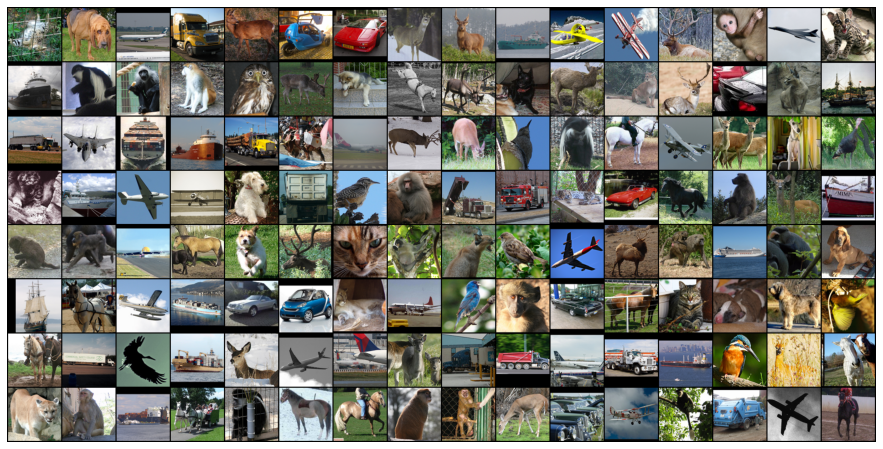

In [18]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Base Model class & Training on GPU

Let's create a base model class, which contains everything except the model architecture i.e. it wil not contain the `__init__` and `__forward__` methods. We will later extend this class to try out different architectures. 

In [19]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [20]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

The exact same training loop as before. 

In [21]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Move  data & labels to the GPU, if one is available.

In [22]:
torch.cuda.is_available()

True

In [23]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [24]:
device = get_default_device()
device

device(type='cuda')

In [25]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Helper functions for plotting the losses & accuracies.

In [26]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [27]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

Let's move our data loaders to the appropriate device.

In [28]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Training the model

We will make several attempts at training the model. Each time, try a different architecture and a different set of learning rates. Here are some ideas to try:
- Increase or decrease the number of hidden layers
- Increase of decrease the size of each hidden layer
- Try different activation functions
- Try training for different number of epochs
- Try different learning rates in every epoch

What's the highest validation accuracy you can get to? **Can you get to 50% accuracy? What about 60%?**

In [29]:
input_size = 3*96*96
output_size = 10


**STL10 Model Definition**


In [30]:
class STL10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.quasi_Linear = nn.Sequential(
            # Hidden layer 1
            nn.Linear(input_size,1024),
            # Activation fuction 1
            nn.PReLU(),
            # Hidden layer 2
            nn.Linear(1024,256),
            # Activation fuction 2
            nn.PReLU(),
            # Hidden layer 3
            nn.Linear(256,64),
            # Activation fuction 3
            nn.PReLU(),
            nn.Linear(64,output_size)
        )
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.quasi_Linear(out)
        return out

We now instantiate the model, and move it the appropriate device.

In [31]:
model = to_device(STL10Model(), device)

Before you train the model, it's a good idea to check the validation loss & accuracy with the initial set of weights.

In [32]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.09437736868858337, 'val_loss': 2.3039016723632812}]

**We Train the model using the `fit` function to reduce the validation loss & improve accuracy.**



In [33]:
epochs,lr =(5,1e-1)
#  in tranin_hyper_para :
print(f" training for {epochs} epochs , with a learning rate of {lr} ...")
history += fit(epochs, lr, model, train_loader, val_loader)

 training for 5 epochs , with a learning rate of 0.1 ...
Epoch [0], val_loss: 2.2013, val_acc: 0.1796
Epoch [1], val_loss: 2.8793, val_acc: 0.1577
Epoch [2], val_loss: 2.4100, val_acc: 0.1746
Epoch [3], val_loss: 2.3888, val_acc: 0.1353
Epoch [4], val_loss: 2.4448, val_acc: 0.2411


In [34]:
epochs,lr =(5,5e-2)
#  in tranin_hyper_para :
print(f" training for {epochs} epochs , with a learning rate of {lr} ...")
history += fit(epochs, lr, model, train_loader, val_loader)

 training for 5 epochs , with a learning rate of 0.05 ...
Epoch [0], val_loss: 2.0215, val_acc: 0.2533
Epoch [1], val_loss: 2.0458, val_acc: 0.2454
Epoch [2], val_loss: 2.0267, val_acc: 0.2634
Epoch [3], val_loss: 1.9941, val_acc: 0.2522
Epoch [4], val_loss: 2.3547, val_acc: 0.1802


In [35]:
epochs,lr =(5,2e-2)
#  in tranin_hyper_para :
print(f" training for {epochs} epochs , with a learning rate of {lr} ...")
history += fit(epochs, lr, model, train_loader, val_loader)

 training for 5 epochs , with a learning rate of 0.02 ...
Epoch [0], val_loss: 1.7893, val_acc: 0.3304
Epoch [1], val_loss: 1.9075, val_acc: 0.2927
Epoch [2], val_loss: 1.7819, val_acc: 0.3286
Epoch [3], val_loss: 1.9016, val_acc: 0.2970
Epoch [4], val_loss: 1.8728, val_acc: 0.2890


In [36]:
epochs,lr =(5,1e-2)
#  in tranin_hyper_para :
print(f" training for {epochs} epochs , with a learning rate of {lr} ...")
history += fit(epochs, lr, model, train_loader, val_loader)

 training for 5 epochs , with a learning rate of 0.01 ...
Epoch [0], val_loss: 1.7539, val_acc: 0.3236
Epoch [1], val_loss: 1.7671, val_acc: 0.3355
Epoch [2], val_loss: 1.7154, val_acc: 0.3683
Epoch [3], val_loss: 1.8174, val_acc: 0.3438
Epoch [4], val_loss: 1.8840, val_acc: 0.2963


In [37]:
epochs,lr =(5,5e-3)
#  in tranin_hyper_para :
print(f" training for {epochs} epochs , with a learning rate of {lr} ...")
history += fit(epochs, lr, model, train_loader, val_loader)

 training for 5 epochs , with a learning rate of 0.005 ...
Epoch [0], val_loss: 1.6866, val_acc: 0.3704
Epoch [1], val_loss: 1.8554, val_acc: 0.3189
Epoch [2], val_loss: 1.6917, val_acc: 0.3819
Epoch [3], val_loss: 1.6951, val_acc: 0.3728
Epoch [4], val_loss: 1.6840, val_acc: 0.3713


In [38]:
epochs,lr =(5,2e-3)
#  in tranin_hyper_para :
print(f" training for {epochs} epochs , with a learning rate of {lr} ...")
history += fit(epochs, lr, model, train_loader, val_loader)

 training for 5 epochs , with a learning rate of 0.002 ...
Epoch [0], val_loss: 1.6710, val_acc: 0.3803
Epoch [1], val_loss: 1.6735, val_acc: 0.3799
Epoch [2], val_loss: 1.6676, val_acc: 0.3786
Epoch [3], val_loss: 1.6644, val_acc: 0.3807
Epoch [4], val_loss: 1.6672, val_acc: 0.3829


Plot the losses and the accuracies to check if you're starting to hit the limits of how well your model can perform on this dataset. You can train some more if you can see the scope for further improvement.

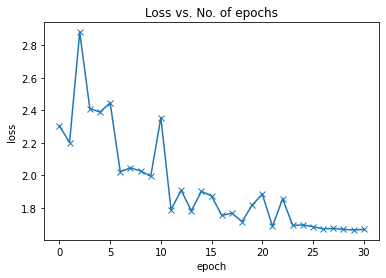

In [39]:
plot_losses(history)

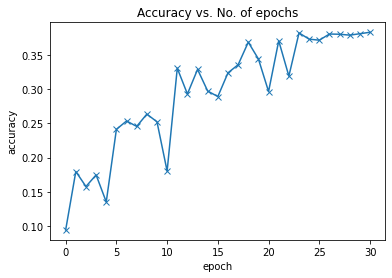

In [40]:
plot_accuracies(history)

Finally, evaluate the model on the test dataset report its final performance.

In [41]:
evaluate(model, test_loader)

{'val_acc': 0.379638671875, 'val_loss': 1.6670829057693481}

## Recoding your results

As your perform multiple experiments, it's important to record the results in a systematic fashion, so that you can review them later and identify the best approaches that you might want to reproduce or build upon later. 



In [42]:
arch = "3 layers (1024,256,64) "
lrs = [1e-1,5e-2,2e-2,1e-2,5e-3,2e-3]
epochs = [5,5,5,5,5,5]

**The final test accuracy & test loss**

In [43]:
test_acc = history
test_loss = history
test_acc,test_loss

([{'val_acc': 0.09437736868858337, 'val_loss': 2.3039016723632812},
  {'val_acc': 0.17958097159862518, 'val_loss': 2.2012500762939453},
  {'val_acc': 0.15771780908107758, 'val_loss': 2.8792569637298584},
  {'val_acc': 0.17463304102420807, 'val_loss': 2.409956693649292},
  {'val_acc': 0.13526278734207153, 'val_loss': 2.3887505531311035},
  {'val_acc': 0.24111032485961914, 'val_loss': 2.444833755493164},
  {'val_acc': 0.2533499002456665, 'val_loss': 2.0214688777923584},
  {'val_acc': 0.2454427033662796, 'val_loss': 2.045837879180908},
  {'val_acc': 0.26335227489471436, 'val_loss': 2.0266685485839844},
  {'val_acc': 0.25217804312705994, 'val_loss': 1.994053602218628},
  {'val_acc': 0.1802438497543335, 'val_loss': 2.3546600341796875},
  {'val_acc': 0.3303622305393219, 'val_loss': 1.7893351316452026},
  {'val_acc': 0.29274383187294006, 'val_loss': 1.9074976444244385},
  {'val_acc': 0.32862216234207153, 'val_loss': 1.781883716583252},
  {'val_acc': 0.2969696819782257, 'val_loss': 1.901578903

Finally, let's save the trained model weights to disk, so we can use this model later.

In [49]:
torch.save(model.state_dict(), 'stl10-proj-feedforward.pth')

The `jovian` library provides some utility functions to keep your work organized. With every version of your notebok, you can attach some hyperparameters and metrics from your experiment.

In [50]:
# Clear previously recorded hyperparams & metrics
jovian.reset()

In [51]:
jovian.log_hyperparams(arch=arch, 
                       lrs=lrs, 
                       epochs=epochs)

[jovian] Hyperparams logged.


In [52]:
jovian.log_metrics(test_loss=test_loss, test_acc=test_acc)

[jovian] Metrics logged.


Finally, we can commit the notebook to Jovian, attaching the hypeparameters, metrics and the trained model weights.

In [53]:
jovian.commit(project=project_name, outputs=['stl10-proj-feedforward.pth'], environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...


[jovian] Error: ('Connection aborted.', BrokenPipeError(32, 'Broken pipe')) (stl10-proj-feedforward.pth)


[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/venkatesh-vran/06-stl10-project


'https://jovian.ai/venkatesh-vran/06-stl10-project'

## The highest validation accuracy we can get was 38% with feed forward neural network

## Now let us try CNN

# Classifying STL10 images using Convolutional Neural Networks in PyTorch

_A.K.A. Training an image classifier from scratch to over 60% accuracy in less than 5 minutes on a single GPU_

### Course project of "Deep Learning with Pytorch: Zero to GANs"

We will use one of the state-of-the-art models pre-trained Resnet  and fine-tune it on the STL-10 dataset. 

We will then use one of the state-of-the-art models pre-trained on the
ImageNet dataset and fine-tune it on the STL-10 dataset .The ImageNet dataset, with over 14 million images and 1,000 categories, is one of the famous datasets that helped to push the boundaries in deep learning models. You can learn more about the ImageNet dataset at http:/​/​www.​image-​net.​org/​.

## Defining the Model (Convolutional Neural Network)

In our [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn), we defined a deep neural network with fully-connected layers using `nn.Linear`. For this tutorial however, we will use a convolutional neural network, using the `nn.Conv2d` class from PyTorch.

> The 2D convolution is a fairly simple operation at heart: you start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel. - [Source](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)

<img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" style="max-width:400px;">


Let us implement a convolution operation on a 1 channel image with a 3x3 kernel.

For multi-channel images, a different kernel is applied to each channels, and the outputs are added together pixel-wise. 

Checking out the following articles to gain a better understanding of convolutions:

1. [Intuitively understanding Convolutions for Deep Learning](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1) by Irhum Shafkat
2. [Convolutions in Depth](https://sgugger.github.io/convolution-in-depth.html) by Sylvian Gugger (this article implements convolutions from scratch)

There are certain advantages offered by convolutional layers when working with image data:

* **Fewer parameters**: A small set of parameters (the kernel) is used to calculate outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer. 
* **Sparsity of connections**: In each layer, each output element only depends on a small number of input elements, which makes the forward and backward passes more efficient.
* **Parameter sharing and spatial invariance**: The features learned by a kernel in one part of the image can be used to detect similar pattern in a different part of another image.

We will also use a [max-pooling](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) layers to progressively decrease the height & width of the output tensors from each convolutional layer.

<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" style="max-width:400px;">

Before we define the entire model, let's look at how a single convolutional layer followed by a max-pooling layer operates on the data.


Refer to [Sylvian's post](https://sgugger.github.io/convolution-in-depth.html) for an explanation of `kernel_size`, `stride` and `padding`.    


The `Conv2d` layer transforms a 3-channel image to a 16-channel *feature map*, and the `MaxPool2d` layer halves the height and width. The feature map gets smaller as we add more layers, until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get vector of size 10 for each image.

<img src="https://i.imgur.com/KKtPOKE.png" style="max-width:540px">

Let's define the model by extending an `ImageClassificationBase` class which contains helper methods for training & validation.

We'll use `nn.Sequential` to chain the layers and activations functions into a single network architecture.

In [54]:
class Stl10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 48 x 48

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 24 x 24

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 12 x 12
            nn.Conv2d(256,512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 6 x 6
            nn.Flatten(), 
            nn.Linear(512*6*6, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [55]:
model = Stl10CnnModel()
model

Stl10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=(1

Let's verify that the model produces the expected output on a batch of training data. The 10 outputs for each image can be interpreted as probabilities for the 10 target classes (after applying softmax), and the class with the highest probability is chosen as the label predicted by the model for the input image. Check out [Part 3 (logistic regression)](https://jovian.ml/aakashns/03-logistic-regression#C50) for a more detailed discussion on interpeting the outputs, applying softmax and identifying the predicted labels.

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required. These are described in more detail in the [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn#C21).

In [56]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [57]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available), and use `to_device` to move our model to the GPU (if available).

In [59]:
val_dl = val_loader
train_dl = train_loader
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [60]:
## Training the Model

#We can use the exact same `fit` and `evaluate` functions as defined in the previous tutorials.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we begin training, let's instantiate the model once again and see how it performs on the validation set with the initial set of parameters.

In [61]:
model = to_device(Stl10CnnModel(), device)

In [62]:
evaluate(model, val_dl)

{'val_acc': 0.09860321879386902, 'val_loss': 2.3032968044281006}

The initial accuracy is around 10%, which is what one might expect from a randomly intialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).
We'll use the following *hyperparmeters* (learning rate, no. of epochs, batch_size etc.) to train our model. As an exercise, you can try changing these to see if you have achieve a higher accuracy in a shorter time. 


In [63]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001

It's important to record the hyperparameters of every experiment you do, to replicate it later and compare it against other experiments. We can record them using `jovian.log_hyperparams`.

In [64]:
jovian.reset()

In [65]:
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

[jovian] Hyperparams logged.


In [66]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], val_loss: 2.0889, val_acc: 0.2056
Epoch [1], val_loss: 2.2507, val_acc: 0.1905
Epoch [2], val_loss: 1.8040, val_acc: 0.3034
Epoch [3], val_loss: 1.6769, val_acc: 0.3260
Epoch [4], val_loss: 1.6004, val_acc: 0.3605
Epoch [5], val_loss: 1.6903, val_acc: 0.3734
Epoch [6], val_loss: 1.7120, val_acc: 0.3703
Epoch [7], val_loss: 1.5322, val_acc: 0.4334
Epoch [8], val_loss: 1.4794, val_acc: 0.4436
Epoch [9], val_loss: 1.7695, val_acc: 0.4223
Epoch [10], val_loss: 1.3976, val_acc: 0.5147
Epoch [11], val_loss: 1.5508, val_acc: 0.5084
Epoch [12], val_loss: 1.6030, val_acc: 0.4946
Epoch [13], val_loss: 1.7205, val_acc: 0.4965
Epoch [14], val_loss: 2.0785, val_acc: 0.5120
Epoch [15], val_loss: 2.2439, val_acc: 0.5065
Epoch [16], val_loss: 2.4937, val_acc: 0.5015
Epoch [17], val_loss: 2.8121, val_acc: 0.5022
Epoch [18], val_loss: 3.2661, val_acc: 0.4949
Epoch [19], val_loss: 3.0991, val_acc: 0.4820
Epoch [20], val_loss: 2.8128, val_acc: 0.5053
Epoch [21], val_loss: 3.1134, val_acc: 0.502

Just as we have recorded the hyperparameters, we can also record the final metrics achieved by the model using `jovian.log_metrics` for reference, analysis and comparison.

In [67]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


We can also plot the valdation set accuracies to study how the model improves over time.

In [68]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

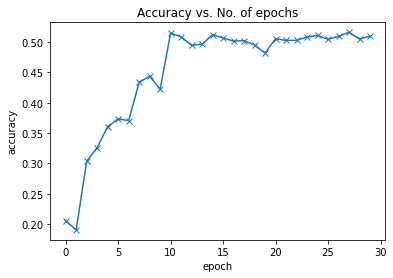

In [69]:
plot_accuracies(history)

Our model reaches an accuracy of around 50%, and by looking at the graph, it seems unlikely that the model will achieve an accuracy higher than 60% even after training for a long time. This suggests that we might need to use a more powerful model to capture the relationship between the images and the labels more accurately. This can be done by adding more convolutional layers to our model, or incrasing the no. of channels in each convolutional layer, or by using regularization techniques.

We can also plot the training and validation losses to study the trend.

In [70]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

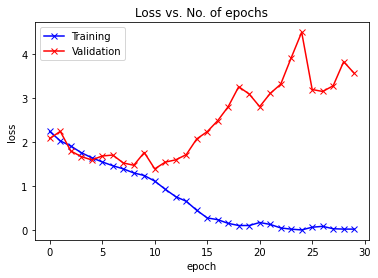

In [71]:
plot_losses(history)

Initialy, both the training and validation losses seem to decrease over time. However, as we  train the model for 30 epochs, we notice that the training loss continues to decrease, while the validation loss stops decreasing, and even starts to increase after 12 epochs ! 

<img src="https://i.stack.imgur.com/1QU0m.png" style="max-width:400px;">

This phenomenon is called **overfitting**, and it is the no. 1 why many machine learning models give rather terrible results on real-world data. It happens because the model, in an attempt to minimize the loss, starts to learn patters are are unique to the training data, sometimes even memorizing specific training examples. Because of this, the model does not generalize well to previously unseen data.

Following are some common stragegies for avoiding overfitting:

- Gathering and generating more training data, or adding noise to it
- Using regularization techniques like batch normalization & dropout
- Early stopping of model's training, when validation loss starts to increase

We will cover these topics in more detail in the next tutorial in this series, and learn how we can reach an accuracy of **over 60%** by making minor but important changes to our model.

Before continuing, let us save our work to the cloud using `jovian.commit`.

In [72]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/venkatesh-vran/06-stl10-project


'https://jovian.ai/venkatesh-vran/06-stl10-project'

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by creating a test dataset using the `ImageFolder` class.

In [73]:
test_dataset = test_ds

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

Label: bird , Predicted: cat


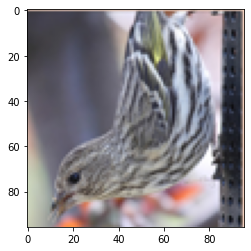

In [75]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: car , Predicted: car


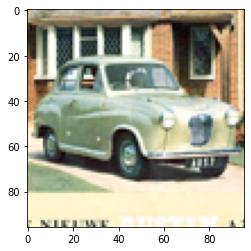

In [76]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: airplane , Predicted: airplane


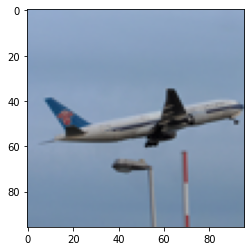

In [77]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

As a final step, let's also look at the overall loss and accuracy of the model on the test set, and record using `jovian`. We expect these values to be similar to those for the validation set. If not, we might need a better validation set that has similar data and distribution as the test set (which often comes from real world data).

In [78]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.5073136687278748, 'val_loss': 3.4122140407562256}

In [79]:
jovian.log_metrics(test_loss=result['val_loss'], test_acc=result['val_acc'])

[jovian] Metrics logged.


## Saving and loading the model

Since we've trained our model for a long time and achieved a resonable accuracy, it would be a good idea to save the weights of the model to disk, so that we can reuse the model later and avoid retraining from scratch. Here's how you can save the model.

In [80]:
torch.save(model.state_dict(), 'stl10-project-cnn.pth')

The `.state_dict` method returns an `OrderedDict` containing all the weights and bias matrices mapped to the right attributes of the model. To load the model weights, we can redefine the model with the same structure, and use the `.load_state_dict` method.

In [84]:
model2 = to_device(Stl10CnnModel(), device)

In [85]:
model2.load_state_dict(torch.load('stl10-project-cnn.pth'))

<All keys matched successfully>

Just as a sanity check, let's verify that this model has the same loss and accuracy on the test set as before.

In [86]:
evaluate(model2, test_loader)

{'val_acc': 0.5073136687278748, 'val_loss': 3.4122140407562256}

Let's make one final commit using `jovian`.

In [87]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/venkatesh-vran/06-stl10-project


'https://jovian.ai/venkatesh-vran/06-stl10-project'

## **The highest validation accuracy is 50%**


## let us try ResNets, Regularization and Data Augmentation in PyTorch

# Classifying STL10 images using ResNets, Regularization and Data Augmentation in PyTorch

_A.K.A. Training an image classifier from scratch to over 90% accuracy in less than 5 minutes on a single GPU_

### Course project of "Deep Learning with Pytorch: Zero to GANs"

We will use one of the state-of-the-art models pre-trained Resnet  and fine-tune it on the STL-10 dataset. 

We will then use one of the state-of-the-art models pre-trained on the
ImageNet dataset and fine-tune it on the STL-10 dataset .The ImageNet dataset, with over 14 million images and 1,000 categories, is one of the famous datasets that helped to push the boundaries in deep learning models. You can learn more about the ImageNet dataset at http:/​/​www.​image-​net.​org/​.


In this tutorial, we'll use the following techniques to train a state-of-the-art model in less than 5 minutes to achieve over 90% accuracy in  classifying images from the STL10 dataset:

- Data normalization
- Data augmentation
- Residual connections
- Batch normalization
- Learning rate scheduling
- Weight Decay
- Gradient clipping
- Adam optimizer

In [88]:
jovian.commit(project= project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/venkatesh-vran/06-stl10-project


'https://jovian.ai/venkatesh-vran/06-stl10-project'

In [89]:
# path to store/load data
dataset = STL10(root='/content/drive/MyDrive/data', download=True, transform=ToTensor())
test_dataset = STL10(root='/content/drive/MyDrive/data', split ='test', transform=ToTensor())
#dataset = STL10(root='data', download=True, transform=ToTensor())
#test_dataset = STL10(root='data', split ='test', transform=ToTensor())
dataset_size = len(dataset)
train_ds = dataset

Files already downloaded and verified


In [93]:
torch.manual_seed(43)
val_size = 1500
test_size = len(test_dataset) - val_size
test_ds, valid_ds = random_split(test_dataset, [test_size, val_size])
len(test_ds), len(val_ds)

(6500, 1500)

We can create training and validation datasets using the `ImageFolder` class from `torchvision`. In addition to the `ToTensor` transform, we'll also apply some other transforms to the images. There are a few important changes we'll make while creating PyTorch datasets for training and validation:

1. **Use test set for validation**: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.
2. **Channel-wise data normalization**: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

<img src="https://i.imgur.com/LYxXBVg.png" width="360">


3. **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

![data-augmentation](https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg)

image indices: [3392 2303 2325 2064]
torch.Size([3, 100, 394])


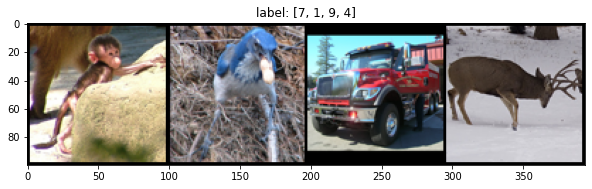

In [91]:
from torchvision import utils
# fix random seed
np.random.seed(43)

def show(img,y=None,color=True):
    npimg = img.numpy()
    npimg_tr=np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)
    if y is not None:
        plt.title("label: "+str(y))
        
grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[train_ds[i][0] for i in rnd_inds]
y_grid=[train_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

image indices: [1344  255  277   58]
torch.Size([3, 100, 394])


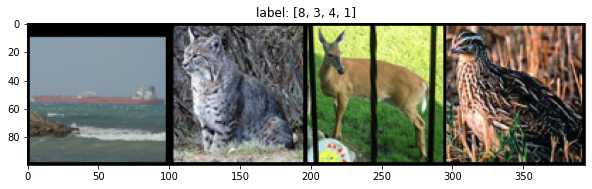

In [94]:
np.random.seed(43)

grid_size=4
rnd_inds=np.random.randint(0,len(valid_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[valid_ds[i][0] for i in rnd_inds]
y_grid=[valid_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

In [126]:
# RGB mean and std 
meanRGB=[np.mean(x.numpy(),axis=(1,2)) for x,_ in train_ds]
stdRGB=[np.std(x.numpy(),axis=(1,2)) for x,_ in train_ds]

meanR=np.mean([m[0] for m in meanRGB])
meanG=np.mean([m[1] for m in meanRGB])
meanB=np.mean([m[2] for m in meanRGB])

stdR=np.mean([s[0] for s in stdRGB])
stdG=np.mean([s[1] for s in stdRGB])
stdB=np.mean([s[2] for s in stdRGB])

print(meanR,meanG,meanB)
print(stdR,stdG,stdB)

1.7910004e-07 -3.5858154e-08 -9.155274e-09
1.0 1.0 1.0


In [127]:
# Data transforms (normalization & data augmentation)
import torchvision.transforms as tt
stats = ((meanR, meanG, meanB), (stdR, stdG, stdB))
train_tfms = tt.Compose([tt.RandomHorizontalFlip(p=0.5),
 tt.RandomVerticalFlip(p=0.5),           
 tt.ToTensor(), 
tt.Normalize(*stats,inplace=True)])
#tt.RandomCrop(32, padding=4, padding_mode='reflect'),
 # tt.RandomRotate
 # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
# tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),                         

valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [128]:
train_ds.transform =  train_tfms
valid_ds.transform =  valid_tfms

In [129]:
batch_size = 300

In [130]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

Let's take a look at some sample images from the training dataloader. To display the images, we'll need to _denormalize_ the pixels values to bring them back into the range `(0,1)`.

In [131]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

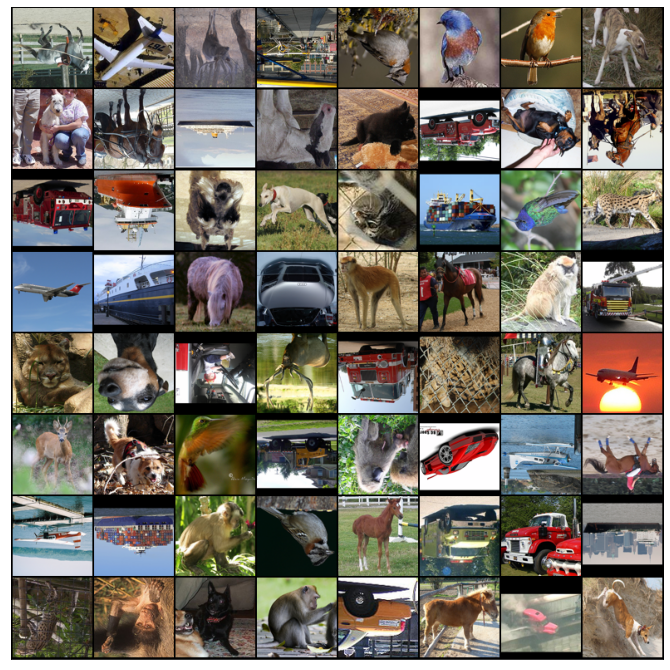

In [132]:
show_batch(train_dl)

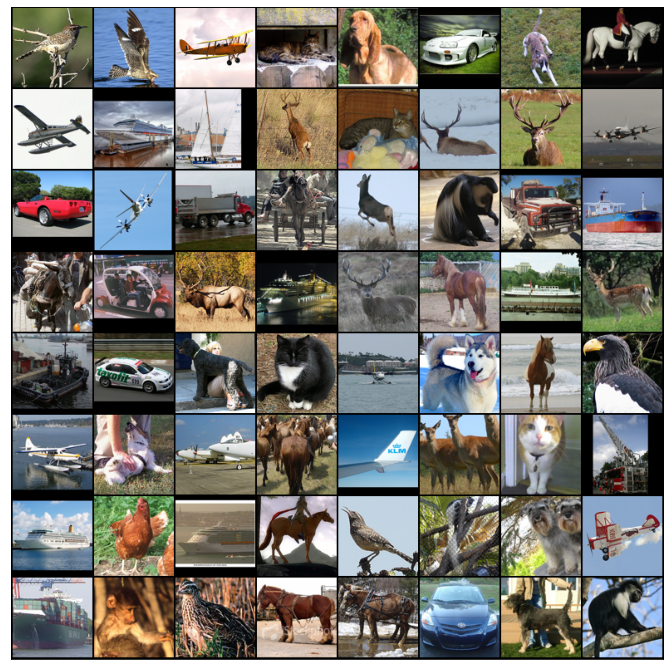

In [133]:
show_batch(valid_dl)

The colors seem out of place because of the normalization. Note that normalization is also applied during inference. If you look closely, you can see the cropping and reflection padding in some of the images. Horizontal flip is a bit difficult to detect from visual inspection.

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required. These are described in more detail in a [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn#C21).

In [134]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [135]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available).

In [136]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model with Residual Blocks and Batch Normalization

One of the key changes to our CNN model this time is the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

Here is a very simple Residual block:

In [137]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [138]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([300, 3, 96, 96])


This seeming small change produces a drastic improvement in the performance of the model. Also, after each convolutional layer, we'll add a batch normalization layer, which normalizes the outputs of the previous layer. 

Go through the following blog posts to learn more:

* Why and how residual blocks work: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec
* Batch normalization and dropout explained: https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd

We will use the ResNet9 architecture, as described in [this blog series](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/) :

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

In [139]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [140]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64,pool=True)
        self.conv2 = conv_block(64, 128, pool=True) # output: 128 x 24 x 24
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True) # output: 256 x 12 x 12
        self.conv4 = conv_block(256, 512, pool=True) # output: 512 x 6 x 6
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [141]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e

## Training the model

Before we train the model, we're going to make a bunch of small but important improvements to our `fit` function:

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

* **Weight decay**: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

* **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48


Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.


In [142]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [143]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.09444444626569748, 'val_loss': 2.302650213241577}]

We're now ready to train our model. Instead of SGD (stochastic gradient descent), we'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. You can learn more about optimizers here: https://ruder.io/optimizing-gradient-descent/index.html

In [144]:
epochs = 32
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [145]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00063, train_loss: 2.0815, val_loss: 3.2795, val_acc: 0.1567
Epoch [1], last_lr: 0.00135, train_loss: 1.6284, val_loss: 2.8943, val_acc: 0.3178
Epoch [2], last_lr: 0.00248, train_loss: 1.4550, val_loss: 3.4437, val_acc: 0.3183
Epoch [3], last_lr: 0.00391, train_loss: 1.4300, val_loss: 2.8977, val_acc: 0.2928
Epoch [4], last_lr: 0.00547, train_loss: 1.4120, val_loss: 1.8866, val_acc: 0.4244
Epoch [5], last_lr: 0.00700, train_loss: 1.3499, val_loss: 2.0628, val_acc: 0.4056
Epoch [6], last_lr: 0.00835, train_loss: 1.3308, val_loss: 4.4044, val_acc: 0.2483
Epoch [7], last_lr: 0.00935, train_loss: 1.4167, val_loss: 3.4109, val_acc: 0.2328
Epoch [8], last_lr: 0.00991, train_loss: 1.3056, val_loss: 2.3131, val_acc: 0.3172
Epoch [9], last_lr: 0.00999, train_loss: 1.3426, val_loss: 3.9364, val_acc: 0.2089
Epoch [10], last_lr: 0.00990, train_loss: 1.1496, val_loss: 2.2205, val_acc: 0.3706
Epoch [11], last_lr: 0.00972, train_loss: 1.0899, val_loss: 1.2758, val_acc: 0.5722
Ep

In [146]:
train_time='2:46'

Our model trained to over 75% accuracy in under 3 minutes. 
Let's plot the valdation set accuracies to study how the model improves over time.

In [147]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

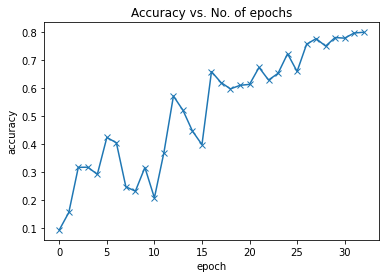

In [148]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend.

In [149]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

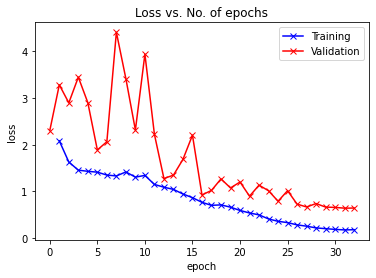

In [150]:
plot_losses(history)

It's clear from the trend that our model isn't overfitting to the training data just yet. Try removing batch normalization, data augmentation and residual layers one by one to study their effect on overfitting.

Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

In [151]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

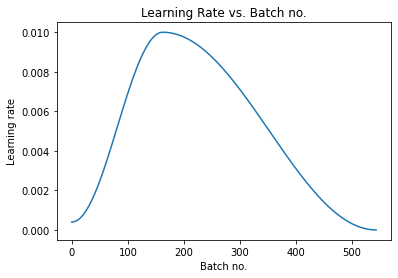

In [152]:
plot_lrs(history)

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of `0.01`, and then gradually decreases to a very small value.

Testing with individual images
While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images.

In [153]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: bird , Predicted: bird


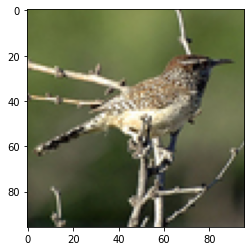

In [154]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: horse , Predicted: horse


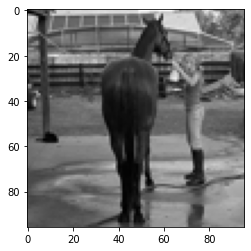

In [155]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: ship , Predicted: ship


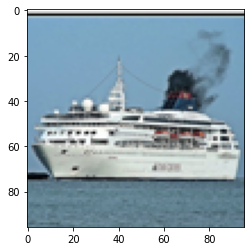

In [156]:
img, label = valid_ds[1200]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

## Save and Commit

Let's save the weights of the model, record the hyperparameters, and commit our experiment to Jovian. As you try different ideas, make sure to record every experiment so you can look back and analyze the results.

In [157]:
torch.save(model.state_dict(), 'stl10-project-resnet9.pth')

In [158]:
!pip install jovian --upgrade --quiet

In [159]:
import jovian

In [160]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [161]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


In [165]:
jovian.commit(project=project_name, environment=None, outputs=['stl10-project-resnet9.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/venkatesh-vran/06-stl10-project


'https://jovian.ai/venkatesh-vran/06-stl10-project'

## Summary of project for zero to GANS course on deep learning


* Introduction to the STL10 dataset for image classification
* Downloading, extracing and loading an image dataset using `torchvision`
* Show random batches of images in a grid using `torchvision.utils.make_grid`
* Creating a feedforward neural network 
* Training a feedforward neural network and visualizing the losses and errors 
## Maximun  accuracy of 38% obtained FFNN
* Creating a convolutional neural network using with `nn.Conv2d` and `nn.MaxPool2d` layers suitable for STL10 data set
* Capturing dataset information, metrics and hyperparameters using the `jovian` library
* Training a convolutional neural network and visualizing the losses and errors.
## Maximum  accuracy of  50 % obtained with CNN
* Understanding overfitting and the strategies for avoiding it (more on this later)
* Generating predictions on single images from the test set
* Saving and loading the model weights, and attaching them to the eperiment snaptshot using `jovian`


Next  we  continued to improve our model's accuracy using techniques like data augmentation, batch normalization and dropout. We modified the residual networks (or ResNets) to suit the STL10 dataset, a small but critical change to the model architecture that  significantly boost the performance of our model. 

We used the following techniques to improve the model performance and reduce the training time:

* **Data normalization**: We normalized the image tensors by subtracting the mean and dividing by the standard deviation of pixels across each channel. Normalizing the data prevents the pixel values from any one channel from disproportionately affecting the losses and gradients. [Learn more](https://medium.com/@ml_kid/what-is-transform-and-transform-normalize-lesson-4-neural-networks-in-pytorch-ca97842336bd)

* **Data augmentation**: We applied random transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. [Learn more](https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/)

* **Residual connections**: One of the key changes to our CNN model was the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers. We used the ResNet9 architecture [Learn more](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec).

* **Batch normalization**: After each convolutional layer, we added a batch normalization layer, which normalizes the outputs of the previous layer. This is somewhat similar to data normalization, except it's applied to the outputs of a layer, and the mean and standard deviation are learned parameters. [Learn more](https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd)

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are [many strategies](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) for varying the learning rate during training, and we used the "One Cycle Learning Rate Policy". [Learn more](https://sgugger.github.io/the-1cycle-policy.html)

* **Weight Decay**: We added weight decay to the optimizer, yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function. [Learn more](https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab)

* **Gradient clipping**: We also added gradient clippint, which helps limit the values of gradients to a small range to prevent undesirable changes in model parameters due to large gradient values during training.  [Learn more.](https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48#63e0)

* **Adam optimizer**: Instead of SGD (stochastic gradient descent), we used the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. There are many other optimizers to choose froma and experiment with. [Learn more.](https://ruder.io/optimizing-gradient-descent/index.html)


##We modified the RESNET 9 architecture to meet the requirements of the STL10 data set and reached an accuracy of ** 80 %**